In [1]:
!. /vol/cuda/11.4.120-cudnn8.2.4/setup.sh
!nvcc --version

/bin/bash: nvcc: command not found


In [9]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import random
from jax.config import config

from inducing_points import random_select

config.update("jax_enable_x64", True)
%matplotlib inline

In [10]:
def func(x):
    """Latent function."""
    return 1.0 * jnp.sin(x * 3 * jnp.pi) + \
           0.3 * jnp.cos(x * 9 * jnp.pi) + \
           0.5 * jnp.sin(x * 7 * jnp.pi)


# Number of training examples
n = 1000

# Number of inducing variables
m = 30

# Noise
sigma_y = 0.2

# Noisy training data
X = jnp.linspace(-1.0, 1.0, n).reshape(-1, 1)
y = func(X) + sigma_y * random.normal(random.PRNGKey(0), shape=(n, 1))

# Test data
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
f_true = func(X_test)

# Inducing inputs
X_m = jnp.linspace(-0.4, 0.4, m).reshape(-1, 1)
# X_m = random_select(X, 30)

X.shape, y.shape, X_m.shape, X_test.shape, f_true.shape

((1000, 1), (1000, 1), (30, 1), (1000, 1), (1000, 1))

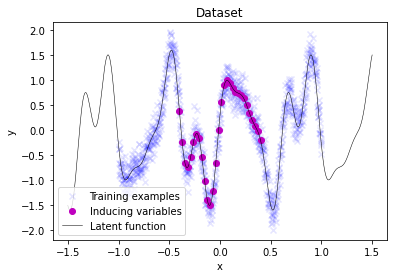

In [11]:
plt.scatter(X, y, label='Training examples', marker='x', color='blue', alpha=0.1)
plt.scatter(X_m, func(X_m), label='Inducing variables', c='m')
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.title('Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [12]:
from models import FCN
from neural_tangents import stax
from snngp import SNNGP
import logger as logging
logger = logging.init_logger(log_level=logging.DEBUG)

model = FCN
model_params = dict(
            kernel_batch_size=0, 
            device_count=-1, 
            num_layers=2, 
            hid_dim=1024, 
            out_dim=10, 
            nonlinearity=stax.Relu
            )

snngp = SNNGP(model=model, hyper_params=model_params, train_data=(X, y), inducing_points=X_m, num_latent_gps=1)

ll = snngp.log_likelihood()
lb = snngp.lower_bound()
ub = snngp.upper_bound()
lb, ll-lb, ub-lb

[2022-07-09 02:14:23,601 DEBUG] (snngp:215) (1000, 1000), (1000, 1)
[2022-07-09 02:14:23,601 DEBUG] (snngp:215) (1000, 1000), (1000, 1)
[2022-07-09 02:14:23,608 DEBUG] (snngp:217) (1000, 1)
[2022-07-09 02:14:23,608 DEBUG] (snngp:217) (1000, 1)
[2022-07-09 02:14:23,610 DEBUG] (snngp:221) -1251.9711755199053
[2022-07-09 02:14:23,610 DEBUG] (snngp:221) -1251.9711755199053
[2022-07-09 02:14:24,188 DEBUG] (snngp:61) kuu: (30, 30)
[2022-07-09 02:14:24,188 DEBUG] (snngp:61) kuu: (30, 30)
[2022-07-09 02:14:24,733 DEBUG] (snngp:63) kuf: (30, 1000)
[2022-07-09 02:14:24,733 DEBUG] (snngp:63) kuf: (30, 1000)
[2022-07-09 02:14:24,734 DEBUG] (snngp:66) L: (30, 30)
[2022-07-09 02:14:24,734 DEBUG] (snngp:66) L: (30, 30)
[2022-07-09 02:14:24,738 DEBUG] (snngp:68) A: (30, 1000)
[2022-07-09 02:14:24,738 DEBUG] (snngp:68) A: (30, 1000)
[2022-07-09 02:14:24,741 DEBUG] (snngp:70) AAT: (30, 30)
[2022-07-09 02:14:24,741 DEBUG] (snngp:70) AAT: (30, 30)
[2022-07-09 02:14:24,746 DEBUG] (snngp:72) B: (30, 30)
[20

(DeviceArray(-1272.71675762, dtype=float64),
 DeviceArray(20.7455821, dtype=float64),
 DeviceArray(269.40873267, dtype=float64))

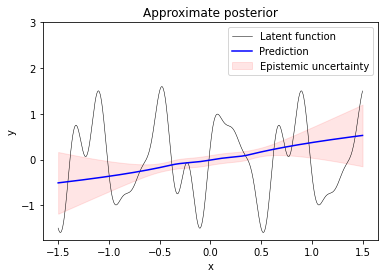

In [13]:
f_test, f_test_cov = snngp.predict(X_test, diag=True)
# f_test_var = np.diag(f_test_cov)
# f_test_std = np.sqrt(f_test_var)
f_test_std = np.sqrt(f_test_cov)

plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.plot(X_test, f_test, label='Prediction', c='b')
plt.fill_between(X_test.ravel(), 
                 f_test.ravel() + 2 * f_test_std.ravel(), 
                 f_test.ravel() - 2 * f_test_std.ravel(),
                 label='Epistemic uncertainty',
                 color='r', alpha=0.1)
plt.title('Approximate posterior')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(None, 3.0)
plt.legend()

In [14]:
opt_params = snngp.optimize()
print(opt_params)
ll = snngp.log_likelihood()
lb = snngp.lower_bound()
ub = snngp.upper_bound()
lb, ll-lb, ub-lb

[2022-07-09 02:14:31,824 INFO] (snngp:231) Optimizing...
[2022-07-09 02:14:31,824 INFO] (snngp:231) Optimizing...
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27272D+03    |proj g|=  2.78129D+01

At iterate    1    f=  1.25178D+03    |proj g|=  5.90661D+01

At iterate    2    f=  1.07230D+03    |proj g|=  1.05622D+02

At iterate    3    f=  1.04994D+03    |proj g|=  5.85104D+01

At iterate    4    f=  1.04883D+03    |proj g|=  4.48413D+01

At iterate    5    f=  1.04802D+03    |proj g|=  1.00830D+01

At iterate    6    f=  1.04788D+03    |proj g|=  8.05555D+00

At iterate    7    f=  1.04772D+03    |proj g|=  3.48405D+00

At iterate    8    f=  1.04764D+03    |proj g|=  3.54183D+00

At iterate    9    f=  1.04752D+03    |proj g|=  1.78792D+01

At iterate   10    f=  1.04731D+03    |proj g|=  1.49675D+01

At iterate   11    f=  1.04146D+03    |proj g|=  7.36097D+01

At iterate   12    f=  1.03674D+03    |proj g|=  6.74056D+01

At iterate   13    f=  1.0

[2022-07-09 02:15:02,280 DEBUG] (snngp:243)       fun: 1010.6053027980579
 hess_inv: <32x32 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.91834584e-03,  4.06298635e-05, -7.35674308e-04, -5.59431573e-04,
        4.00578312e-04, -4.77161622e-04, -5.69601856e-04, -4.80734401e-04,
       -7.37569561e-03,  5.40586533e-03,  7.24197937e-03, -2.16218430e-02,
       -2.65170858e-04,  3.37319765e-03, -3.05436439e-03, -3.89459568e-04,
        1.58422621e-03, -6.89313687e-03,  4.39475678e-03, -4.92935037e-03,
        2.40741019e-03, -1.21707479e-03, -1.14170556e-03, -2.61139439e-03,
       -1.71005917e-03,  1.51678137e-03, -3.86818692e-03, -2.22566541e-03,
       -1.92347034e-03, -5.34860377e-03,  1.04588098e-03,  1.64141120e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 243
      nit: 198
     njev: 243
   status: 0
  success: True
        x: array([ 4.41927010e+00,  4.82058638e+00, -9.82758514e-01, -9.18430255e-01,
       -7.58685002e-01, -8.39927518


At iterate  197    f=  1.01061D+03    |proj g|=  1.00148D-02

At iterate  198    f=  1.01061D+03    |proj g|=  2.16218D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32    198    244      1     1     0   2.162D-02   1.011D+03
  F =   1010.6053027980579     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[2022-07-09 02:15:02,839 DEBUG] (snngp:61) kuu: (30, 30)
[2022-07-09 02:15:02,839 DEBUG] (snngp:61) kuu: (30, 30)
[2022-07-09 02:15:03,391 DEBUG] (snngp:63) kuf: (30, 1000)
[2022-07-09 02:15:03,391 DEBUG] (snngp:63) kuf: (30, 1000)
[2022-07-09 02:15:03,393 DEBUG] (snngp:66) L: (30, 30)
[2022-07-09 02:15:03,393 DEBUG] (snngp:66) L: (30, 30)
[2022-07-09 02:15:03,396 DEBUG] (snngp:68) A: (30, 1000)
[2022-07-09 02:15:03,396 DEBUG] (snngp:68) A: (30, 1000)
[2022-07-09 02:15:03,399 DEBUG] (snngp:70) AAT: (30, 30)
[2022-07-09 02:15:03,399 DEBUG] (snngp:70) AAT: (30, 30)
[2022-07-09 02:15:03,403 DEBUG] (snngp:72) B: (30, 30)
[2022-07-09 02:15:03,403 DEBUG] (snngp:72) B: (30, 30)
[2022-07-09 02:15:03,407 DEBUG] (snngp:74) LB: (30, 30)
[2022-07-09 02:15:03,407 DEBUG] (snngp:74) LB: (30, 30)


[4.43124118 4.82861612]


[2022-07-09 02:15:04,745 DEBUG] (snngp:215) (1000, 1000), (1000, 1)
[2022-07-09 02:15:04,745 DEBUG] (snngp:215) (1000, 1000), (1000, 1)
[2022-07-09 02:15:04,752 DEBUG] (snngp:217) (1000, 1)
[2022-07-09 02:15:04,752 DEBUG] (snngp:217) (1000, 1)
[2022-07-09 02:15:04,754 DEBUG] (snngp:221) -1009.5336194376956
[2022-07-09 02:15:04,754 DEBUG] (snngp:221) -1009.5336194376956


(DeviceArray(-1010.6053028, dtype=float64),
 DeviceArray(1.07168336, dtype=float64),
 DeviceArray(27.78154259, dtype=float64))

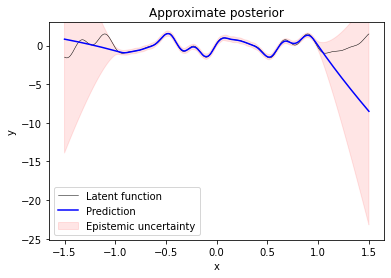

In [15]:
f_test, f_test_cov = snngp.predict(X_test, diag=True)
# f_test_var = np.diag(f_test_cov)
# f_test_std = np.sqrt(f_test_var)
f_test_std = np.sqrt(f_test_cov)

plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.plot(X_test, f_test, label='Prediction', c='b')
plt.fill_between(X_test.ravel(), 
                 f_test.ravel() + 2 * f_test_std.ravel(), 
                 f_test.ravel() - 2 * f_test_std.ravel(),
                 label='Epistemic uncertainty',
                 color='r', alpha=0.1)
plt.title('Approximate posterior')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(None, 3.0)
plt.legend()

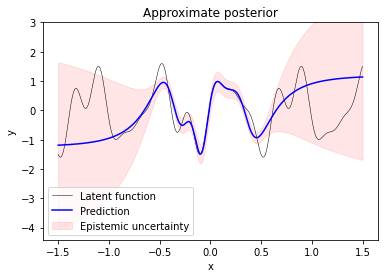

In [7]:
# f_test, f_test_cov = snngp.predict1(X_test, opt_params)
# f_test_var = np.diag(f_test_cov)
# f_test_std = np.sqrt(f_test_var)

# plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
# plt.plot(X_test, f_test, label='Prediction', c='b')
# plt.fill_between(X_test.ravel(), 
#                  f_test.ravel() + 2 * f_test_std, 
#                  f_test.ravel() - 2 * f_test_std,
#                  label='Epistemic uncertainty',
#                  color='r', alpha=0.1)
# plt.title('Approximate posterior')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.ylim(None, 3.0)
# plt.legend()

In [9]:
var = np.array([[1,2],[3,4]])
var1 = var[None, ...]
var1 = np.tile(var1, [3, 1, 1])
var, var1

(array([[1, 2],
        [3, 4]]),
 array([[[1, 2],
         [3, 4]],
 
        [[1, 2],
         [3, 4]],
 
        [[1, 2],
         [3, 4]]]))

In [10]:
var.shape, var[None, ...].shape, var1.shape

((2, 2), (1, 2, 2), (3, 2, 2))

In [14]:
np.diag(var)[:, None].shape, np.tile(np.diag(var)[:, None], [1, 3]).shape

((2, 1), (2, 3))